# Resampling Visualization

This notebook is used to generate example figures for project page https://sahahn.github.io/parc_scaling/resample_parcellations

In [1]:
from nilearn.plotting import plot_surf_stat_map, plot_surf_roi, plot_roi
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import os

from config import matlab_bin_loc, conv_script_loc, freesurfer_loc
from helpers import load_medial_wall, vol_labels_to_surf, volume_to_surf
from nilearn.surface import load_surf_data
from nilearn import datasets

In [2]:
# Load medial wall
mw_mask = load_medial_wall(annot_loc='../raw/fs_LR_32k_label/medialwall.annot')

lh_mesh = '/home/sage/Neuro_Plotting/data/32k_fs_LR/surf/lh.inflated'
lh_sulc = '/home/sage/Neuro_Plotting/data/32k_fs_LR/surf/lh.sulc_conte.gii'

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')

### Visualize Re-sampling from volumetric parcellations

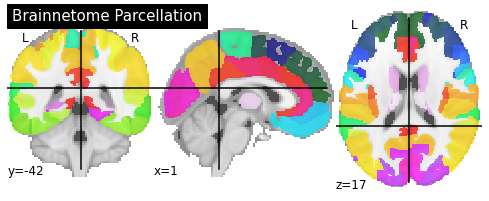

In [3]:
# Load Data
vol = nib.load('../raw/brainnetome/BN_Atlas_246_1mm.nii.gz')

# Viz
plot_roi(vol, title="Brainnetome Parcellation")
plt.savefig('Figures/full_volume.png', dpi=150, transparent=True, bbox_inches='tight')

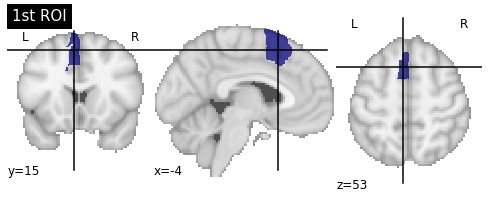

In [4]:
# Split ROIs - just do first
data = vol.get_fdata()
unique_parcels = np.unique(data)
temp = np.zeros(data.shape)
temp[data == np.unique(data)[1]] = 1
temp_as_vol = nib.Nifti1Image(temp, affine=vol.affine)

# Plot
plot_roi(temp_as_vol, title="1st ROI")
plt.savefig('Figures/volume_one_roi.png', dpi=150, transparent=True, bbox_inches='tight')

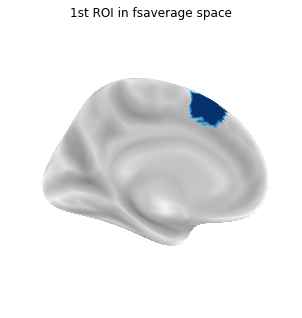

In [5]:
# Resample from volume to FreeSurfer space
cwd = os.getcwd()

temp_name = 'temp'
in_file_loc = os.path.join(cwd, temp_name + '.nii')

# Save temp as input
nib.save(temp_as_vol, in_file_loc)

cmd = 'bash ' + conv_script_loc + ' -s ' + in_file_loc + ' -o ' 
cmd += cwd + ' -m ' + matlab_bin_loc + ' -f ' + freesurfer_loc

# Run the command
os.system(cmd)
os.remove(in_file_loc)

ext = '.allSub_RF_ANTs_MNI152_orig_to_fsaverage.nii.gz'
lh_loc = os.path.join(cwd, 'lh.' + temp_name + ext)
lh_fs_surf = load_surf_data(lh_loc)

# Plot viz
plot_surf_stat_map(fsaverage.infl_left, lh_fs_surf,
                   hemi='left', view='medial',
                   bg_map=fsaverage.sulc_left,
                   colorbar=False,
                   cmap='Blues',
                   darkness=.5,
                   threshold=.01,
                   title='1st ROI in fsaverage space')

plt.savefig('Figures/freesurfer_surface_one_roi.png', dpi=150, transparent=True, bbox_inches='tight')

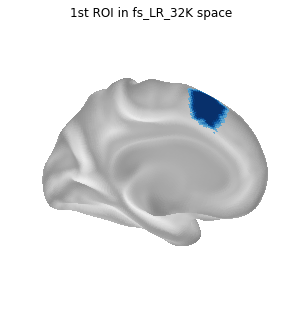

In [6]:
# Do whole resampling / clean up end up in fs_lr_32k space
lh, rh = volume_to_surf(temp_as_vol)

plot_surf_stat_map(lh_mesh, lh,
                   hemi='left', view='medial',
                   bg_map=lh_sulc,
                   colorbar=False,
                   cmap='Blues',
                   darkness=.5,
                   threshold=.01,
                   title='1st ROI in fs_LR_32K space')

plt.savefig('Figures/fs_lr_surface_one_roi.png', dpi=150, transparent=True, bbox_inches='tight')

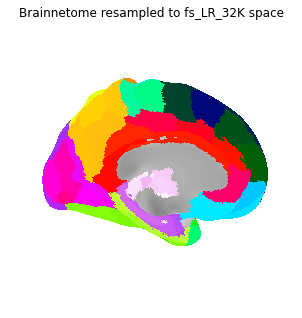

In [7]:
final = vol_labels_to_surf(vol)

final_lh = final[:len(final) // 2]

plot_surf_roi(lh_mesh, final_lh,
              hemi='left', view='medial',
              bg_map=lh_sulc,
              colorbar=False,
              darkness=.5,
              title='Brainnetome resampled to fs_LR_32K space')

plt.savefig('Figures/full_resample.png', dpi=150, transparent=True, bbox_inches='tight')

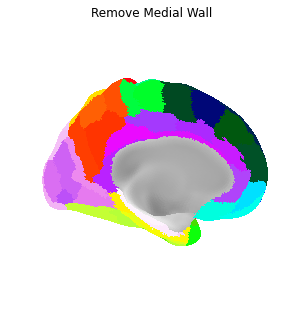

In [8]:
final[mw_mask] = 0

final_lh = final[:len(final) // 2]

plot_surf_roi(lh_mesh, final_lh,
              hemi='left', view='medial',
              bg_map=lh_sulc,
              colorbar=False,
              darkness=.5,
              title='Remove Medial Wall')

plt.savefig('Figures/final_no_medial_wall.png', dpi=150, transparent=True, bbox_inches='tight')